# Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim

# Data Cleaning

In [3]:
df = pd.read_csv('Data.csv')

In [4]:
df

,Date,Average Prices (EUR/MWh)
0,2010-07-21,47.803208
1,2010-07-22,58.061250
2,2010-07-23,46.146042
3,2010-07-24,43.593292
4,2010-07-25,19.148125
...,...,...
2717,2017-12-27,30.209583
2718,2017-12-28,33.220417
2719,2017-12-29,23.760000
2720,2017-12-30,24.729167


In [5]:
df = df.dropna(axis=0)

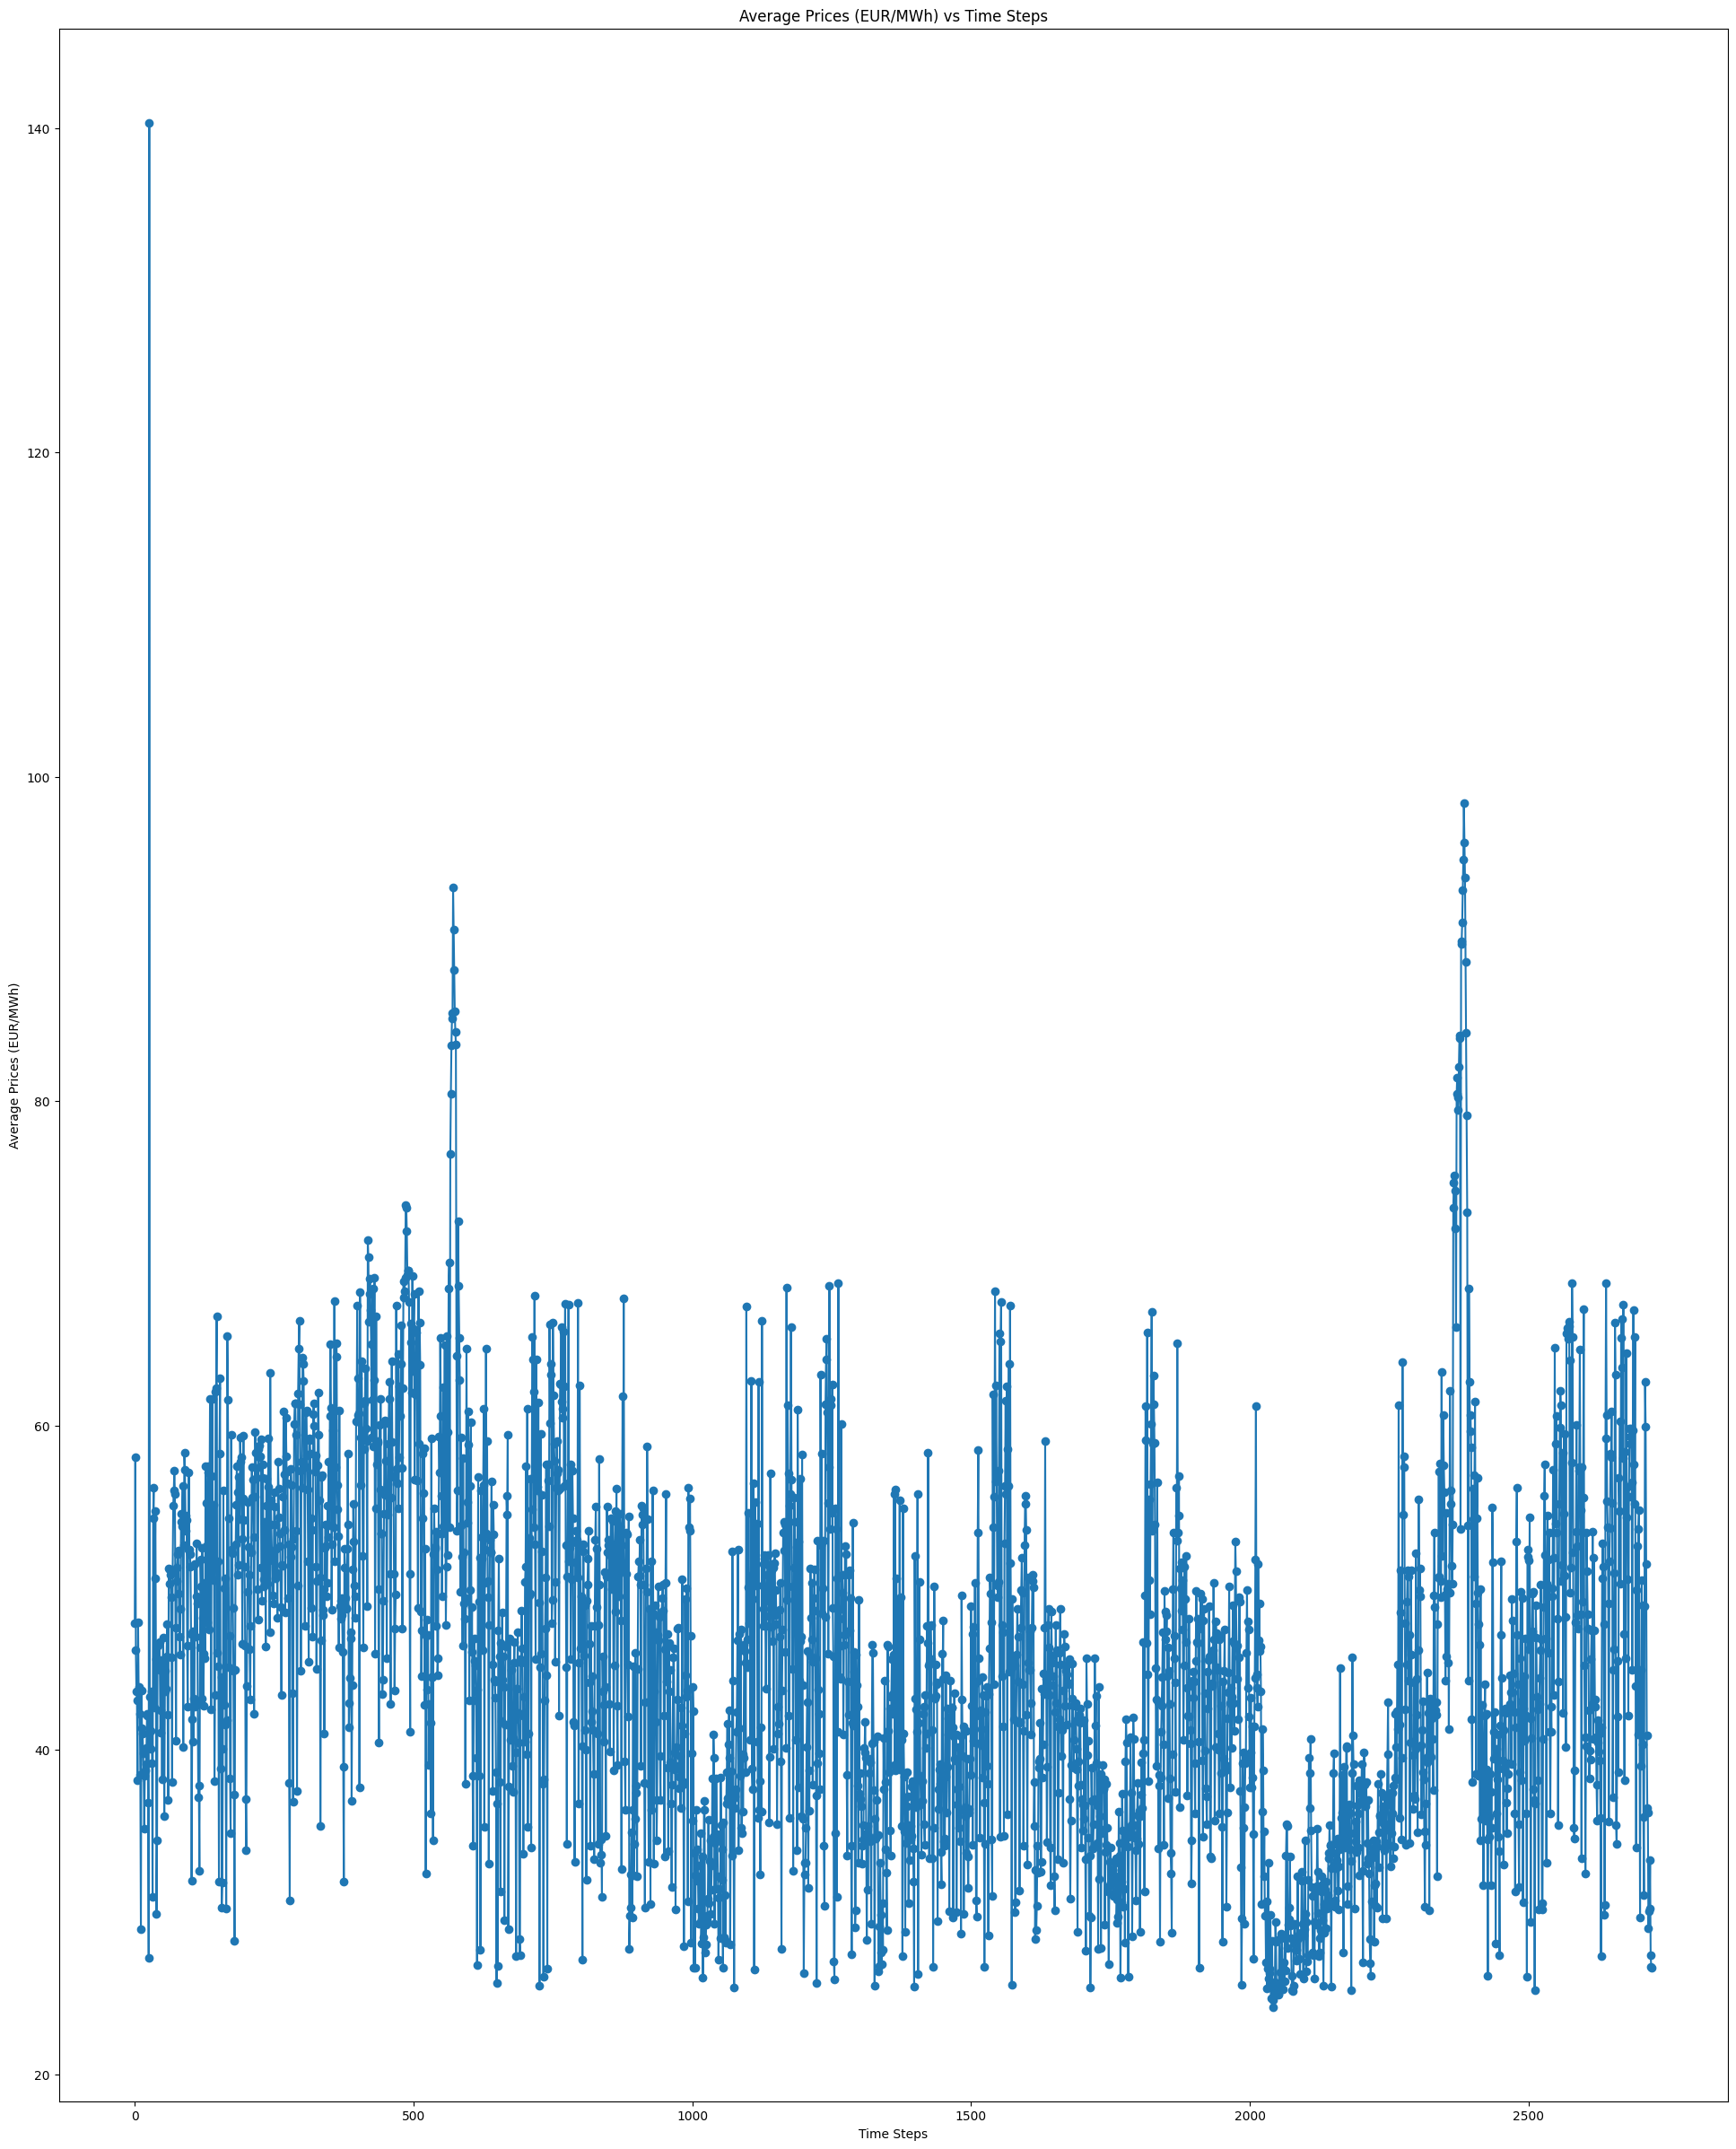

In [11]:
plt.figure(figsize=(24, 30))
plt.plot(df['Average Prices (EUR/MWh)'], marker='o')
plt.title('Average Prices (EUR/MWh) vs Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Average Prices (EUR/MWh)')
plt.show()

In [12]:
print(len(df))

2720


In [13]:
# Find the threshold values for bottom 1% and top 1%
data = pd.to_numeric(df['Average Prices (EUR/MWh)'], errors='coerce')

# Find the threshold values for bottom 1% and top 1%
bottom_threshold = data.quantile(0.05)
top_threshold = data.quantile(0.95)

# Identify the indices that need to be replaced
indices_to_replace = (data < bottom_threshold) | (data > top_threshold)

# Iterate over the indices to replace values with the average of 5 values before and after
for index in indices_to_replace.index:
    if indices_to_replace[index]:
        idx = df.index.get_loc(index)
        # Calculate the average of 5 values before and after
        avg_value = data.iloc[max(0, idx - 5):min(len(df), idx + 6)].mean()
        data.at[index] = avg_value

In [14]:
print(len(data))

2720


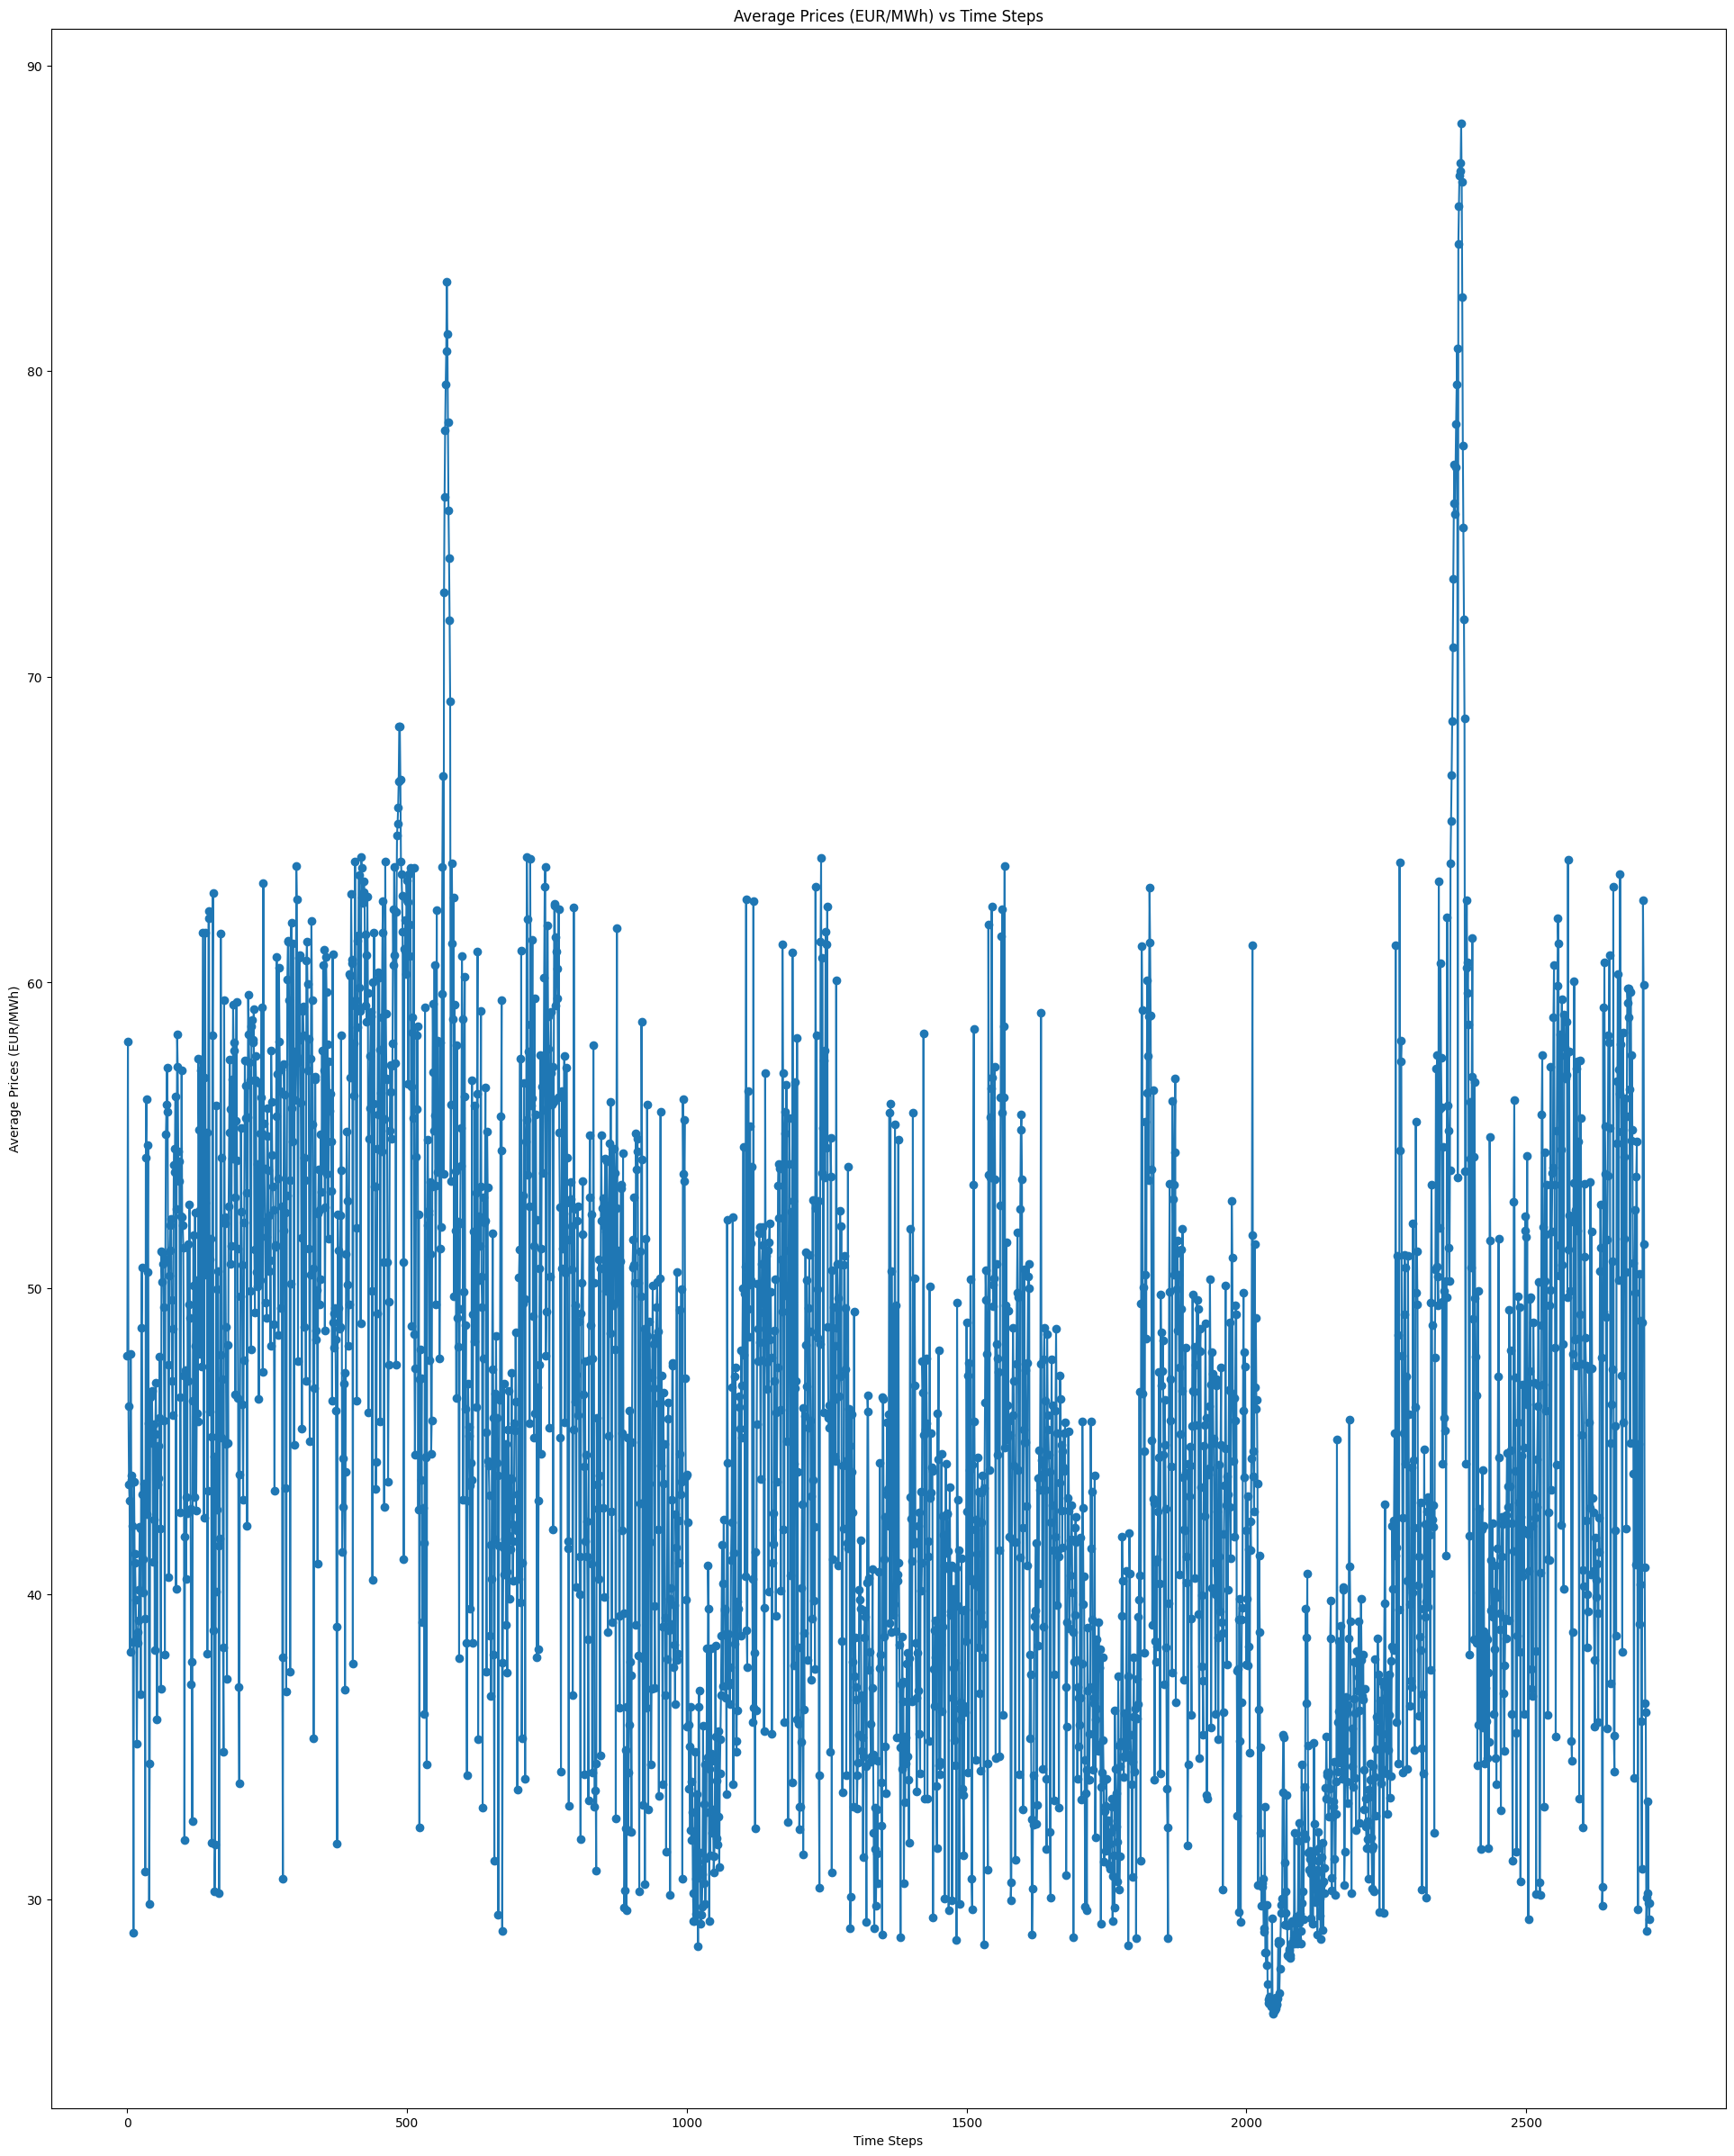

In [16]:
plt.figure(figsize=(24, 30))
plt.plot(data, marker='o')
plt.title('Average Prices (EUR/MWh) vs Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Average Prices (EUR/MWh)')
plt.show()

In [17]:
window_size = 7
data = data.rolling(window=window_size).mean()

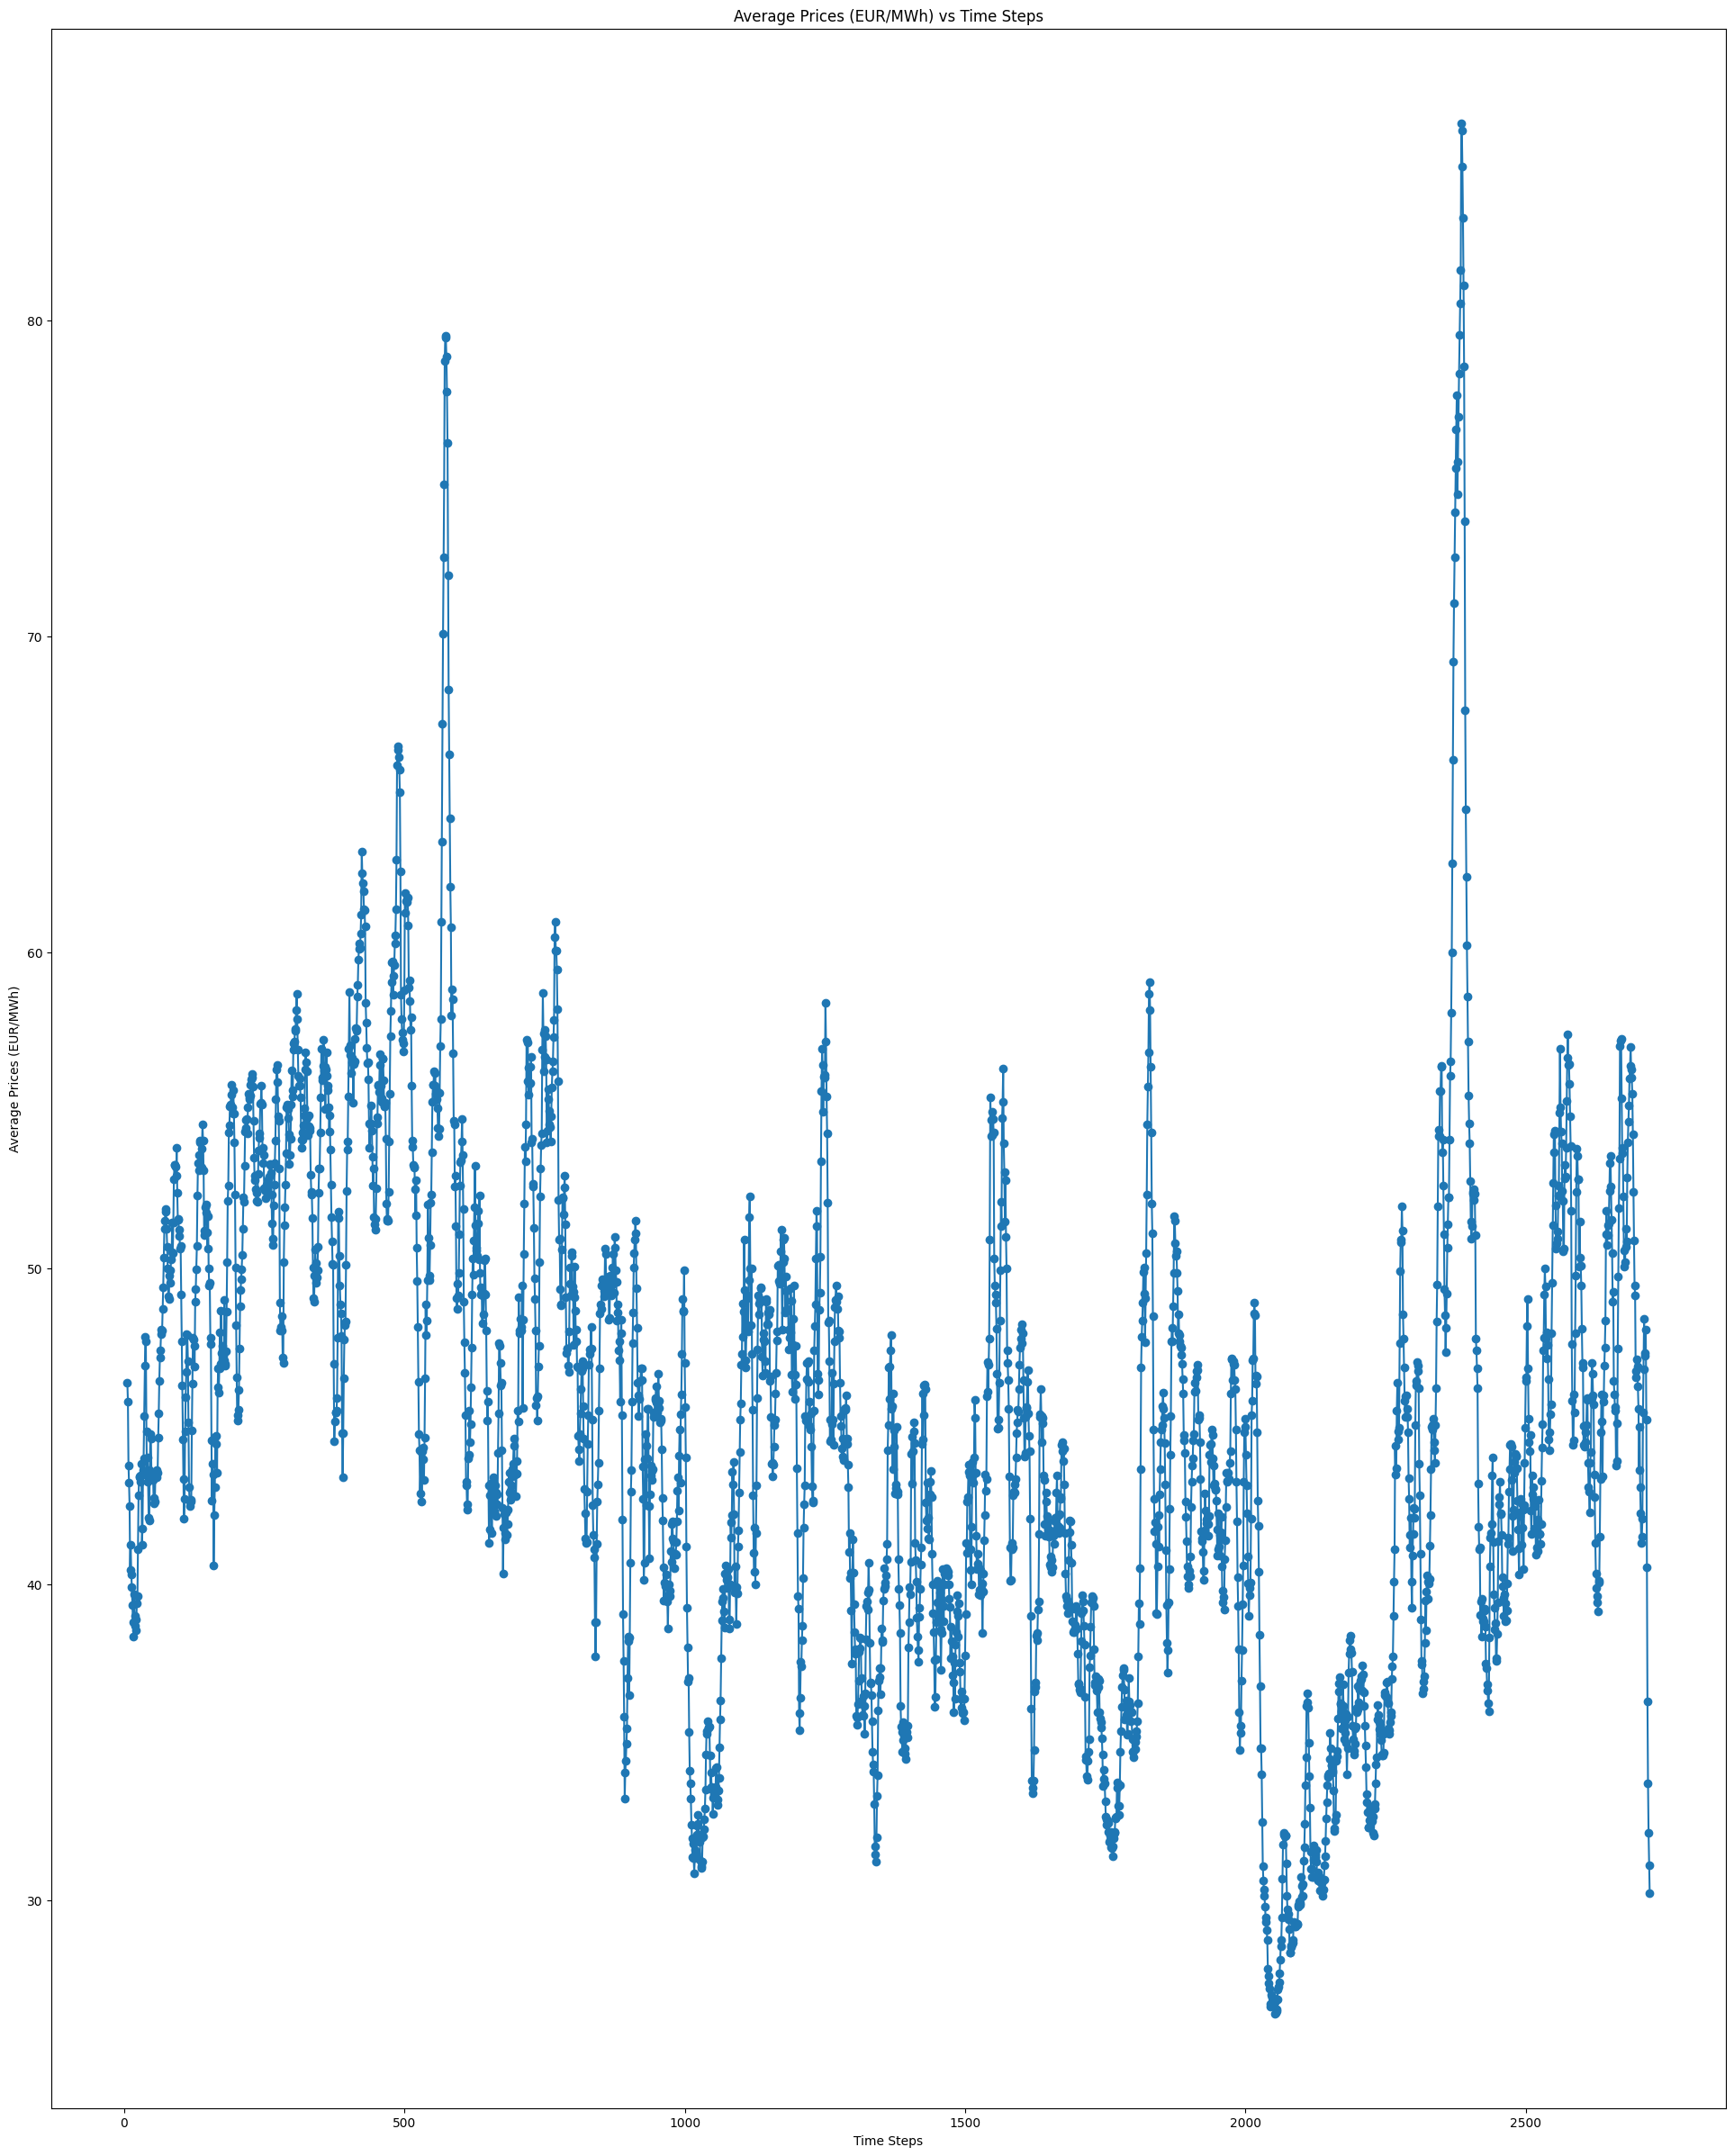

In [18]:
plt.figure(figsize=(24, 30))
plt.plot(data, marker='o')
plt.title('Average Prices (EUR/MWh) vs Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Average Prices (EUR/MWh)')
plt.show()

In [19]:
print(len(data))

2720


In [20]:
data = data.dropna()

In [21]:
print(len(data))

2714


# Since we have to train **univariate** LSTM  we will train them on 'Average Prices (EUR/MWh) ' column  

In [22]:
from sklearn.preprocessing import StandardScaler

data = data.values.reshape(-1, 1)


scaler = StandardScaler()
scaler = scaler.fit(data)
scaled_data = scaler.transform(data)

# test % = 20 
#train % = 80

train_size = int(len(data)*0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

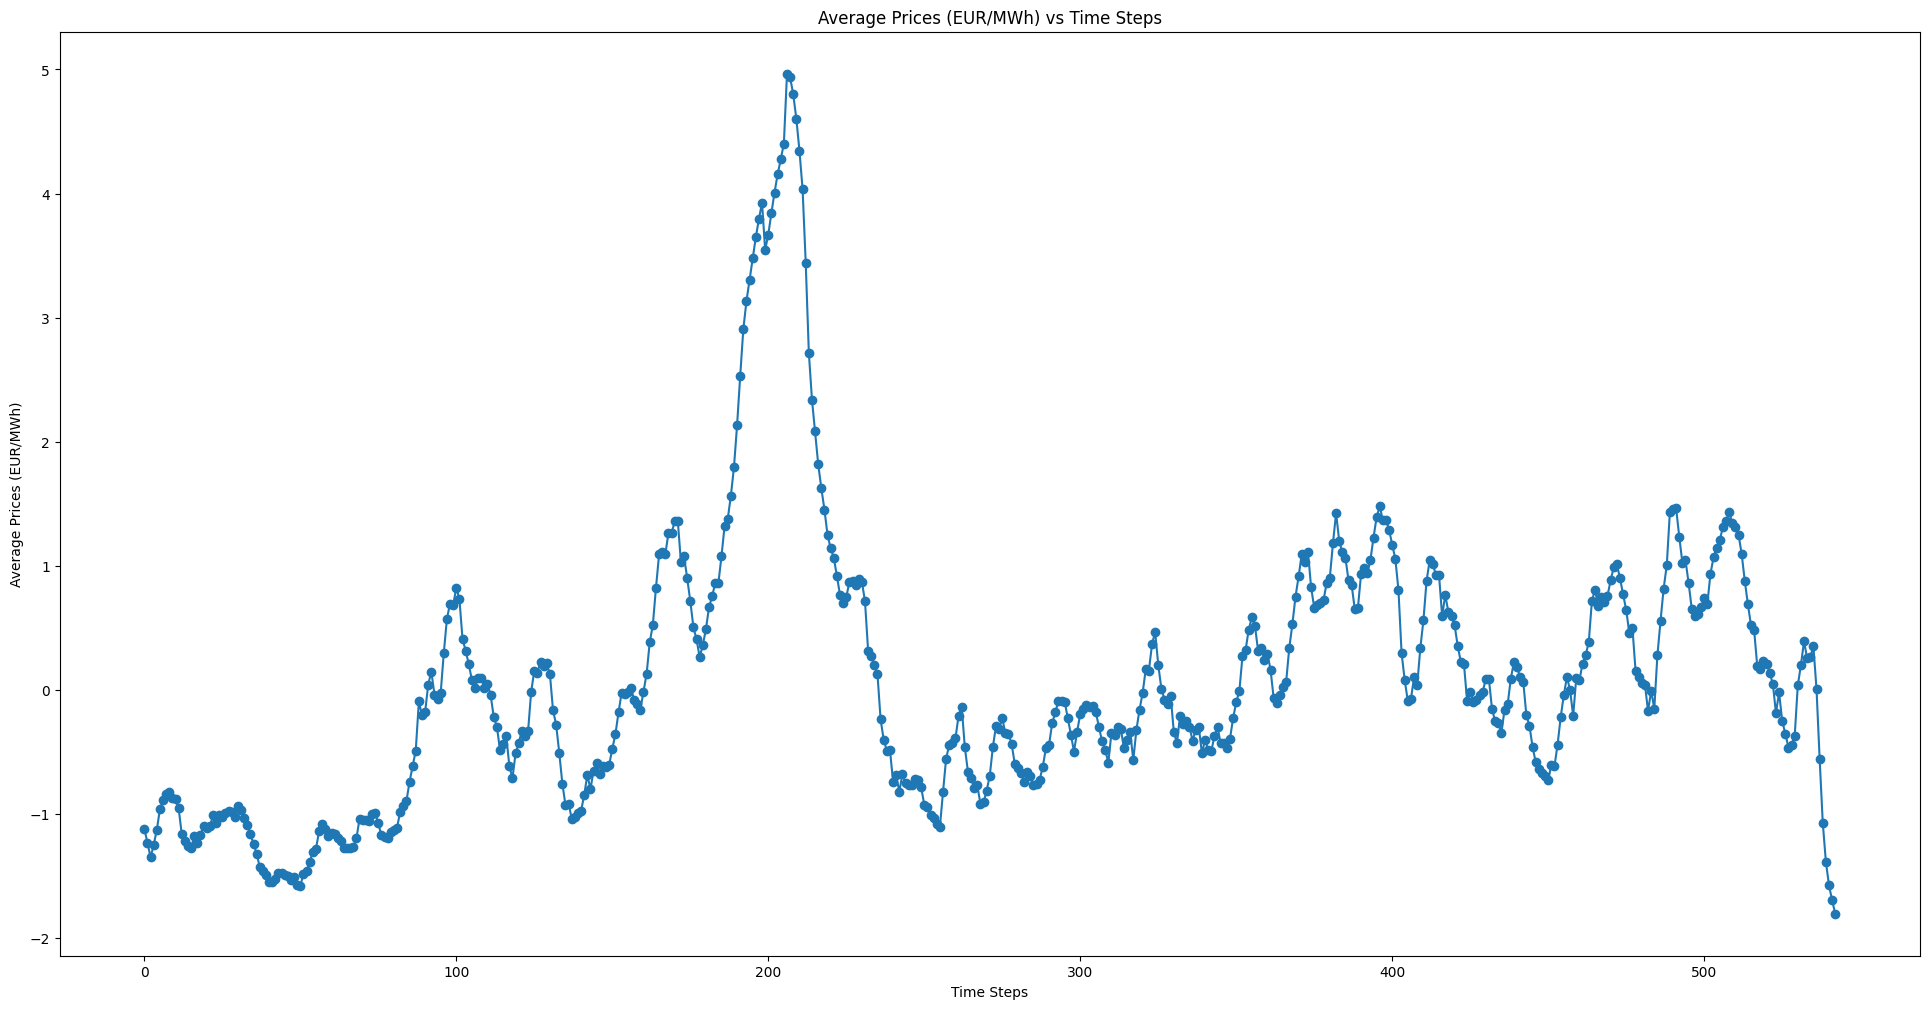

In [59]:
plt.figure(figsize=(24, 12))
plt.plot(test_data, marker='o')
plt.title('Average Prices (EUR/MWh) vs Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Average Prices (EUR/MWh)')
plt.savefig('0.png')
plt.show()

In [24]:
trainX = []
trainY = []

n_future = 1
n_past = 7

for i in range(n_past, len(train_data) - n_future + 1):
    trainX.append(train_data[i - n_past:i, 0])
    trainY.append(train_data[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

testX, testY = [], []

for i in range(n_past, len(test_data) - n_future + 1):
    testX.append(test_data[i - n_past:i, 0])
    testY.append(test_data[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

In [25]:
print(trainX.shape)
print(trainY.shape)

(2164, 7)
(2164, 1)


## Now the preprocessing is done its time to define the **LSTM model**
# Model 1

In [26]:
import torch.nn.functional as F

class ImprovedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.2):
        super(ImprovedLSTM, self).__init__()

        self.lstm1 = nn.LSTM(input_size, hidden_size1, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1 * 2, hidden_size2, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size2 * 2, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size1 * 2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2 * 2)

    def forward(self, input):
        # LSTM layers
        lstm1_out, _ = self.lstm1(input)
        lstm2_out, _ = self.lstm2(lstm1_out)

        # Global average pooling
        avg_pool = F.adaptive_avg_pool1d(lstm2_out.permute(0, 2, 1), 1).view(input.size(0), -1)

        # Linear layer
        output = self.linear(self.batch_norm2(self.dropout(self.relu(avg_pool))))

        return output

# Training function

In [27]:
def train_lstm(model, train_loader, num_epochs=10, learning_rate=0.001, weight_decay=1e-5):
    # Define loss function and optimizer with weight decay
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for inputs, targets in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            
            if torch.isnan(outputs).any():
                print("Outputs before loss calculation:", outputs)
                raise ValueError("Model output contains NaN.")
            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the total loss
            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}')

    print('Training complete.')



## required shape transform to required formats 

In [28]:
from torch.utils.data import DataLoader, TensorDataset

trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

trainX_tensor = trainX_tensor.unsqueeze(-1)
testX_tensor = testX_tensor.unsqueeze(-1)

# Create DataLoader for training
train_dataset = TensorDataset(trainX_tensor, trainY_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [29]:
input_size = 1  # Number of features in the input
hidden_size1 = 128
hidden_size2 = 128
output_size = 1  # Number of output features

model1 = ImprovedLSTM(input_size, hidden_size1, hidden_size2, output_size)

# Assuming you have a DataLoader named train_loader
# and you have defined your own dataset

# Adjust the hyperparameters as needed
num_epochs = 10
learning_rate = 0.001
weight_decay = 1e-5

train_lstm(model1, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, weight_decay=weight_decay)

Epoch 1/10, Loss: 0.2558
Epoch 2/10, Loss: 0.1330
Epoch 3/10, Loss: 0.0879
Epoch 4/10, Loss: 0.0906
Epoch 5/10, Loss: 0.0715
Epoch 6/10, Loss: 0.0589
Epoch 7/10, Loss: 0.0670
Epoch 8/10, Loss: 0.0562
Epoch 9/10, Loss: 0.0653
Epoch 10/10, Loss: 0.0580
Training complete.


Root Mean Squared Error (RMSE): 3.7436
R-squared: 0.8374318016053957


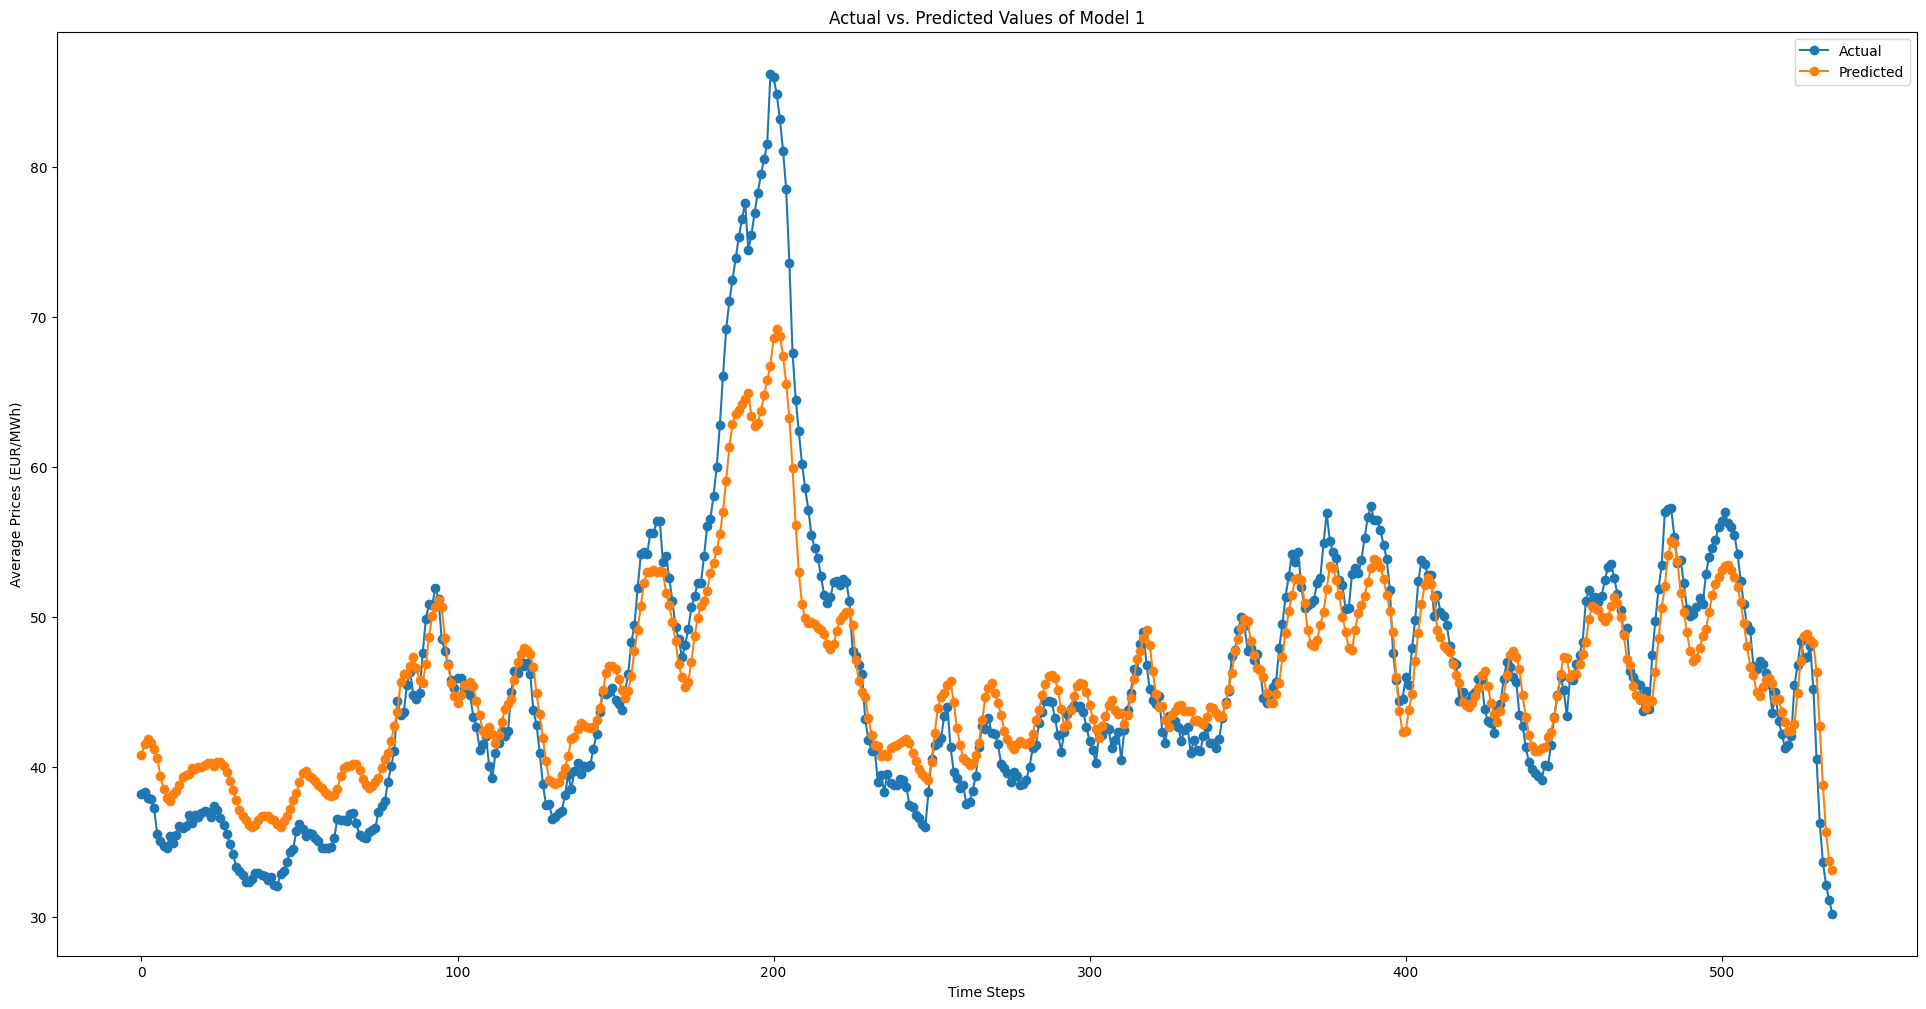

In [54]:
from sklearn.metrics import mean_squared_error, r2_score


# Ensure the model is in evaluation mode
model1.eval()

# Convert the test data to PyTorch tensor and add an extra dimension
testX_tensor = torch.FloatTensor(testX).unsqueeze(-1)

# Make predictions
with torch.no_grad():
    predictions = model1(testX_tensor)

# Invert the scaling to get predictions in the original scale
predictions = scaler.inverse_transform(predictions.numpy())
testY_actual = scaler.inverse_transform(testY)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(testY_actual, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
r_sq = r2_score(testY_actual, predictions)
print('R-squared:', r_sq)
# Plot actual vs. predicted values
plt.figure(figsize=(24, 12))
plt.plot(testY_actual, label='Actual', marker='o')
plt.plot(predictions, label='Predicted', marker='o')
plt.title('Actual vs. Predicted Values of Model 1')
plt.xlabel('Time Steps')
plt.ylabel('Average Prices (EUR/MWh)')
plt.legend()
plt.show()

# Model2

In [41]:
class BetterLSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.5):
        super(BetterLSTM, self).__init__()

        self.lstm1 = nn.LSTMCell(input_size, hidden_size1)
        self.lstm2 = nn.LSTMCell(hidden_size1, hidden_size2)
        self.linear1 = nn.Linear(hidden_size2, hidden_size2)
        self.linear2 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, input):
        batch_size = input.size(0)
        h1_t = torch.zeros(batch_size, self.lstm1.hidden_size, dtype=torch.float32, device=input.device)
        c1_t = torch.zeros(batch_size, self.lstm1.hidden_size, dtype=torch.float32, device=input.device)
        h2_t = torch.zeros(batch_size, self.lstm2.hidden_size, dtype=torch.float32, device=input.device)
        c2_t = torch.zeros(batch_size, self.lstm2.hidden_size, dtype=torch.float32, device=input.device)

        for t in range(input.size(1)):
            h1_t, c1_t = self.lstm1(input[:, t, :], (h1_t, c1_t))
            h2_t, c2_t = self.lstm2(h1_t, (h2_t, c2_t))

        output = self.relu(h2_t)
        output = self.dropout(output)
        output = self.linear1(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.linear2(output)

        return output

In [42]:
# Example usage:
# Adjust the architecture by modifying hyperparameters or layer sizes
input_size = 1
hidden_size1 = 256
hidden_size2 = 128
output_size = 1
dropout_rate = 0.25

model2 = BetterLSTM(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

train_lstm(model2, train_loader, num_epochs=10, learning_rate=0.001)

Epoch 1/10, Loss: 0.4913
Epoch 2/10, Loss: 0.1516
Epoch 3/10, Loss: 0.0784
Epoch 4/10, Loss: 0.0672
Epoch 5/10, Loss: 0.0476
Epoch 6/10, Loss: 0.0468
Epoch 7/10, Loss: 0.0372
Epoch 8/10, Loss: 0.0340
Epoch 9/10, Loss: 0.0362
Epoch 10/10, Loss: 0.0339
Training complete.


Root Mean Squared Error (RMSE): 1.2609
R-squared: 0.9815568235140907


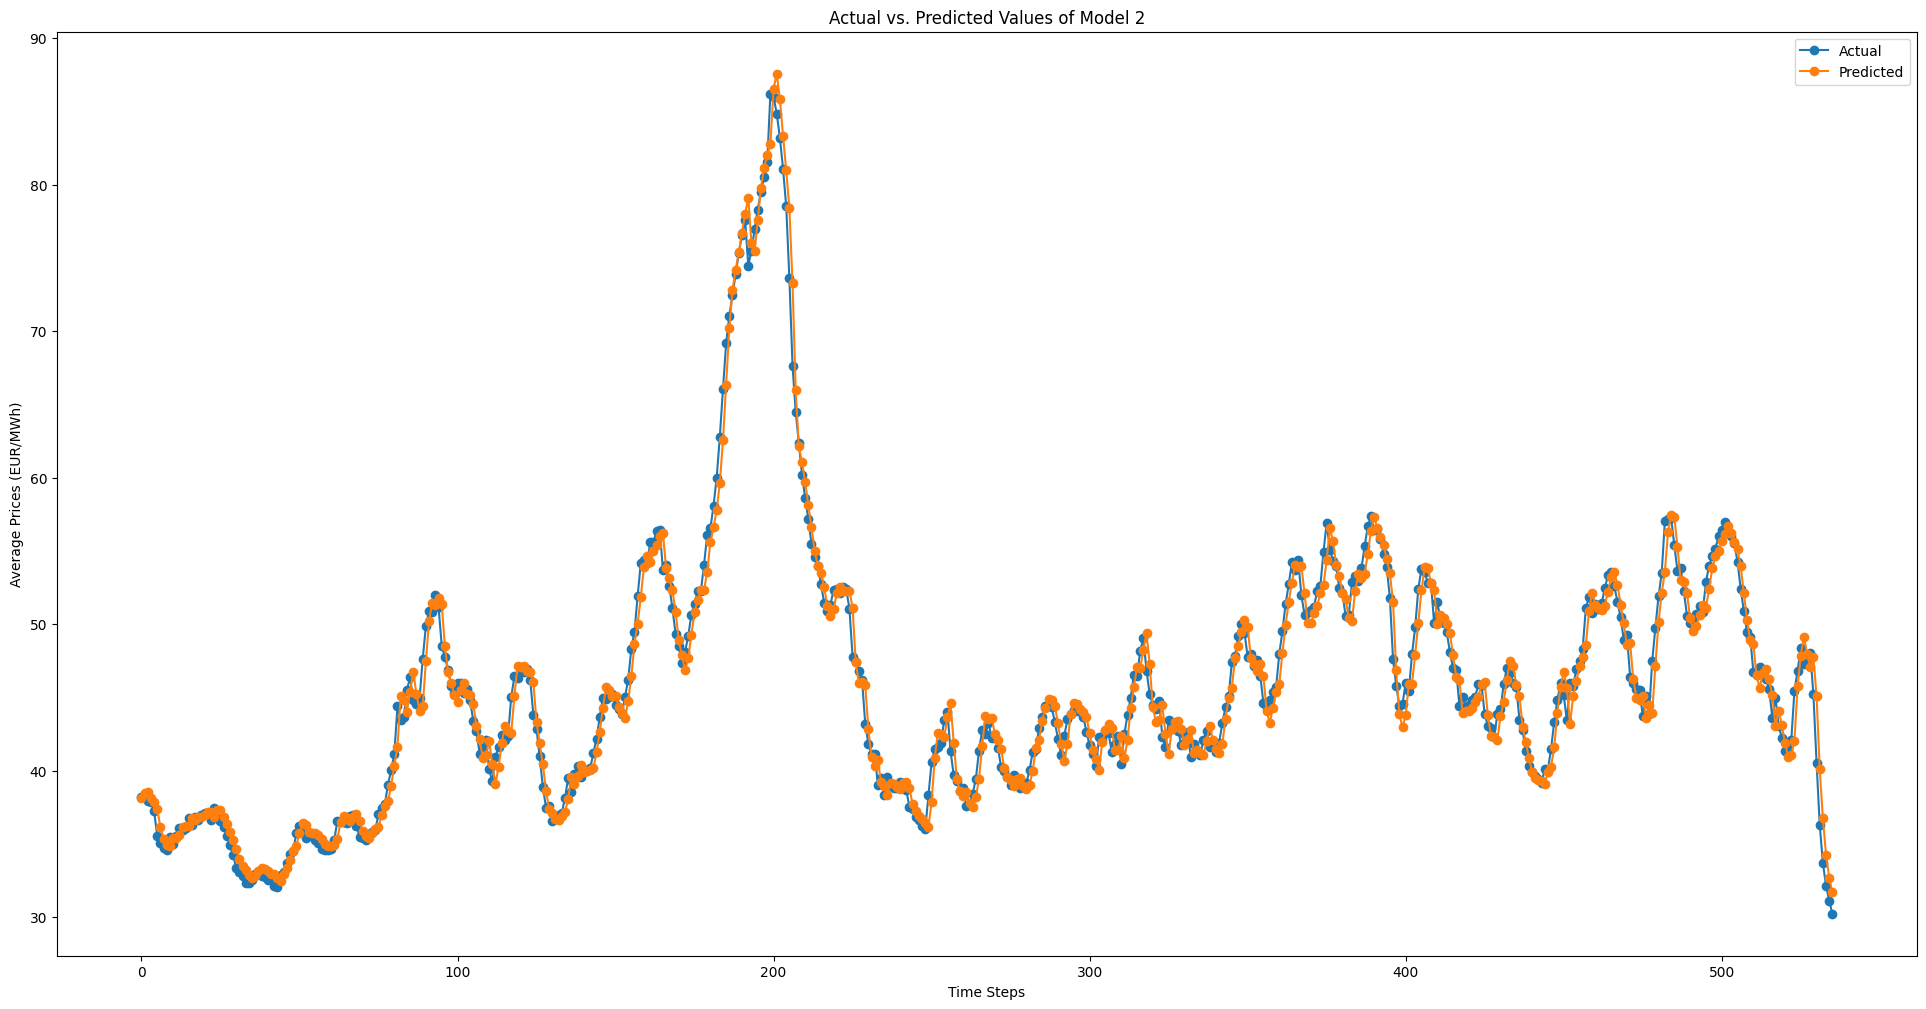

In [52]:
# Ensure the model is in evaluation mode
model2.eval()

# Convert the test data to PyTorch tensor and add an extra dimension
testX_tensor = torch.FloatTensor(testX).unsqueeze(-1)

# Make predictions
with torch.no_grad():
    predictions = model2(testX_tensor)

# Invert the scaling to get predictions in the original scale
predictions = scaler.inverse_transform(predictions.numpy())
testY_actual = scaler.inverse_transform(testY)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(testY_actual, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
from sklearn.metrics import r2_score
r_sq = r2_score(testY_actual, predictions)
print('R-squared:', r_sq)
# Plot actual vs. predicted values
plt.figure(figsize=(24, 12))
plt.plot(testY_actual, label='Actual', marker='o')
plt.plot(predictions, label='Predicted', marker='o')
plt.title('Actual vs. Predicted Values of Model 2')
plt.xlabel('Time Steps')
plt.ylabel('Average Prices (EUR/MWh)')
plt.legend()
plt.show()

# Model3

In [44]:
# Example usage:
# Assuming you have a DataLoader named train_loader containing your training
input_size = 1
hidden_size1 = 256
hidden_size2 = 256
output_size = 1
dropout_rate = 0.25

model3 = BetterLSTM(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

train_lstm(model3, train_loader, num_epochs=10, learning_rate=0.001)

Epoch 1/10, Loss: 0.3728
Epoch 2/10, Loss: 0.1080
Epoch 3/10, Loss: 0.0555
Epoch 4/10, Loss: 0.0412
Epoch 5/10, Loss: 0.0357
Epoch 6/10, Loss: 0.0300
Epoch 7/10, Loss: 0.0300
Epoch 8/10, Loss: 0.0264
Epoch 9/10, Loss: 0.0265
Epoch 10/10, Loss: 0.0254
Training complete.


Root Mean Squared Error (RMSE): 1.1797


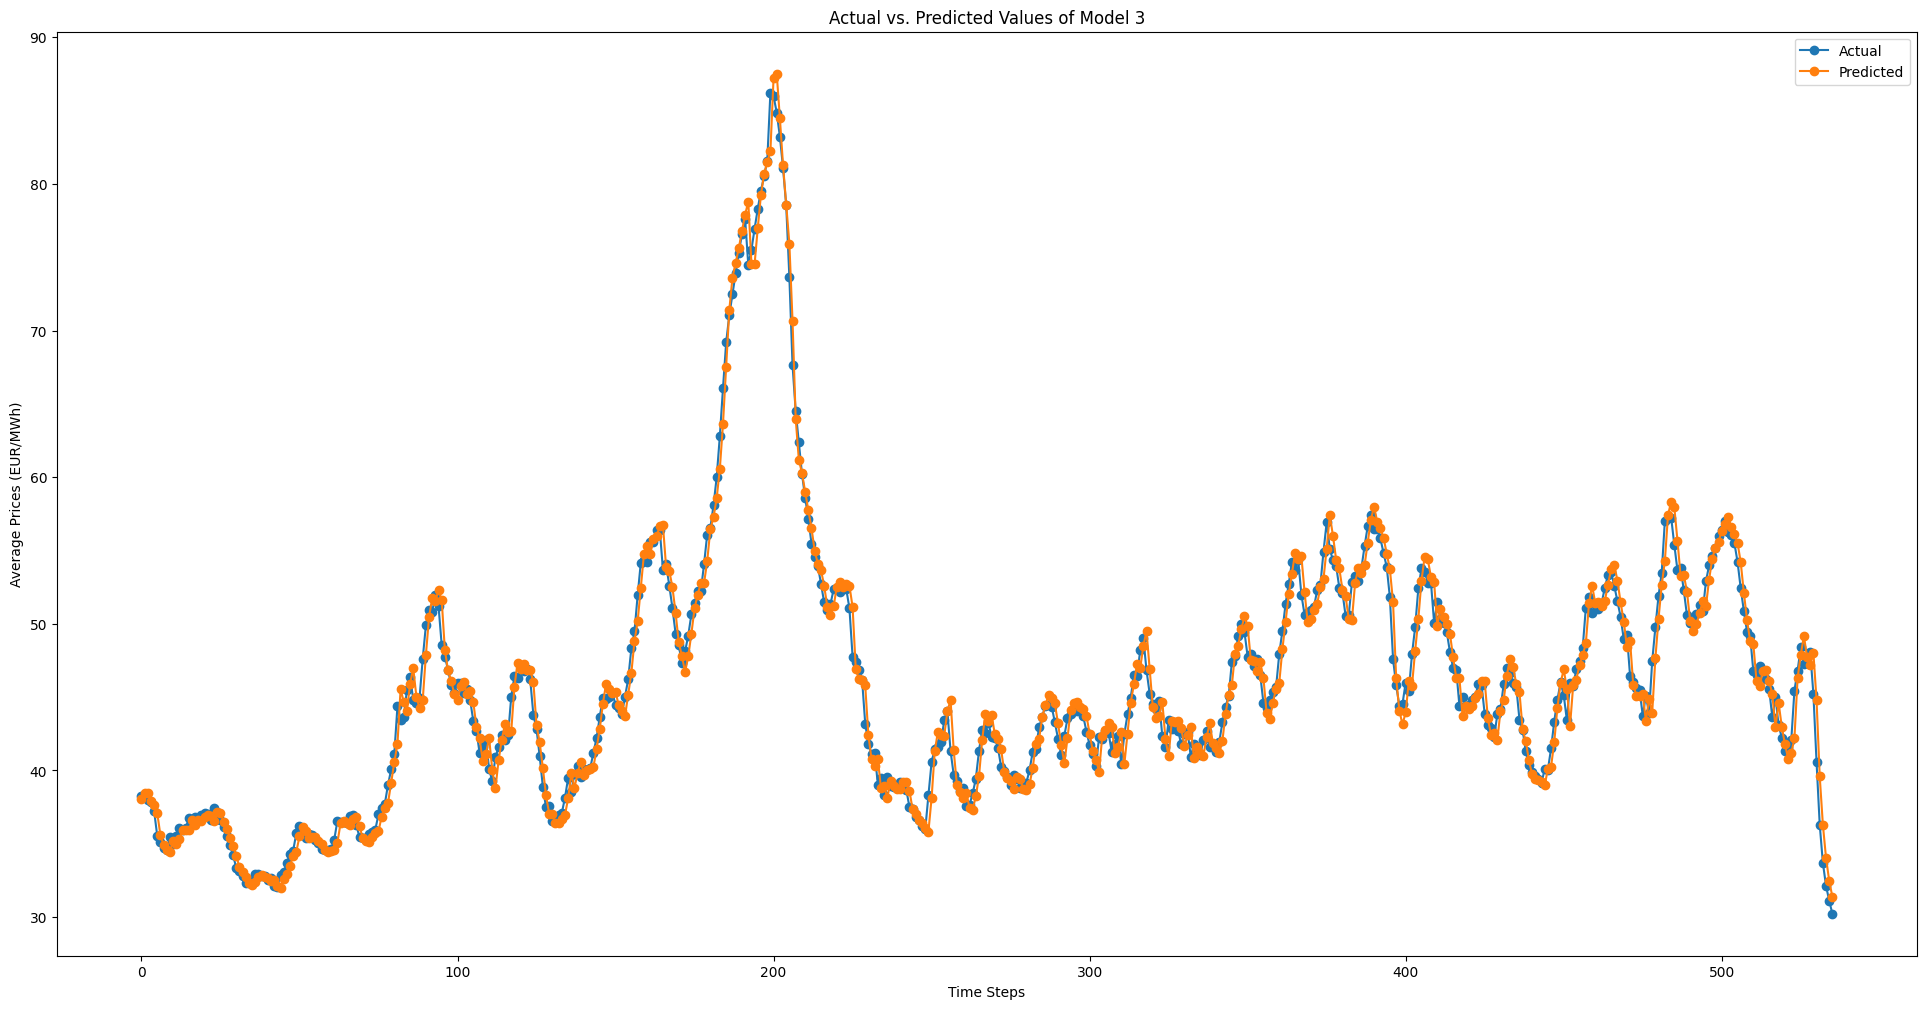

In [55]:
from sklearn.metrics import mean_squared_error

# Ensure the model is in evaluation mode
model3.eval()

# Convert the test data to PyTorch tensor and add an extra dimension
testX_tensor = torch.FloatTensor(testX).unsqueeze(-1)

# Make predictions
with torch.no_grad():
    predictions = model3(testX_tensor)

# Invert the scaling to get predictions in the original scale
predictions = scaler.inverse_transform(predictions.numpy())
testY_actual = scaler.inverse_transform(testY)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(testY_actual, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

# Plot actual vs. predicted values
plt.figure(figsize=(24, 12))
plt.plot(testY_actual, label='Actual', marker='o')
plt.plot(predictions, label='Predicted', marker='o')
plt.title('Actual vs. Predicted Values of Model 3')
plt.xlabel('Time Steps')
plt.ylabel('Average Prices (EUR/MWh)')
plt.legend()
plt.show()

# Model3 is the best, general trend that we can see with increasing number of parameters the model performance also increases


## Calculating R^2

In [47]:
from sklearn.metrics import r2_score

r_sq = r2_score(testY_actual, predictions)
print('R-squared:', r_sq)

R-squared: 0.98385760752408


## Making prediction for 2018

In [48]:
testX_tensor

tensor([[[-1.1183],
         [-1.2280],
         [-1.3486],
         ...,
         [-1.1267],
         [-0.9597],
         [-0.8863]],

        [[-1.2280],
         [-1.3486],
         [-1.2471],
         ...,
         [-0.9597],
         [-0.8863],
         [-0.8347]],

        [[-1.3486],
         [-1.2471],
         [-1.1267],
         ...,
         [-0.8863],
         [-0.8347],
         [-0.8175]],

        ...,

        [[ 0.2546],
         [ 0.2645],
         [ 0.3529],
         ...,
         [-0.5543],
         [-1.0675],
         [-1.3822]],

        [[ 0.2645],
         [ 0.3529],
         [ 0.0092],
         ...,
         [-1.0675],
         [-1.3822],
         [-1.5720]],

        [[ 0.3529],
         [ 0.0092],
         [-0.5543],
         ...,
         [-1.3822],
         [-1.5720],
         [-1.6938]]])

In [49]:
# # Generate a date range for the year 2018
date_range_2018 = pd.date_range(start='2018-01-01', end='2018-12-31')

# Make predictions for each day in 2018 using the trained model
with torch.no_grad():
    predictions_2018 = model3(testX_tensor)

# Convert the predictions to numpy array
predictions_2018 = predictions_2018.numpy()

# Invert the scaling to get predictions in the original scale
predictions_2018 = scaler.inverse_transform(predictions_2018)

# Calculate the average price for each day
average_prices_2018 = np.mean(predictions_2018, axis=1)

# Ensure that the lengths of date_range_2018 and average_prices_2018 are the same
if len(date_range_2018) != len(average_prices_2018):
    # Handle the discrepancy by trimming or padding one of the arrays
    min_length = min(len(date_range_2018), len(average_prices_2018))
    date_range_2018 = date_range_2018[:min_length]
    average_prices_2018 = average_prices_2018[:min_length]

# Create a DataFrame to store the predicted average prices
predictions_2018_df = pd.DataFrame({'Date': date_range_2018, 'Predicted_Average_Price': average_prices_2018})
pd.options.display.float_format = '{:.2f}'.format

# Save the DataFrame to a CSV file
predictions_2018_df.to_csv('Predictions_2018.csv', index=False)

# Print the DataFrame
print(predictions_2018_df)

          Date  Predicted_Average_Price
0   2018-01-01                    38.05
1   2018-01-02                    38.43
2   2018-01-03                    38.48
3   2018-01-04                    37.92
4   2018-01-05                    37.67
..         ...                      ...
360 2018-12-27                    45.98
361 2018-12-28                    48.28
362 2018-12-29                    50.12
363 2018-12-30                    52.01
364 2018-12-31                    53.41

[365 rows x 2 columns]


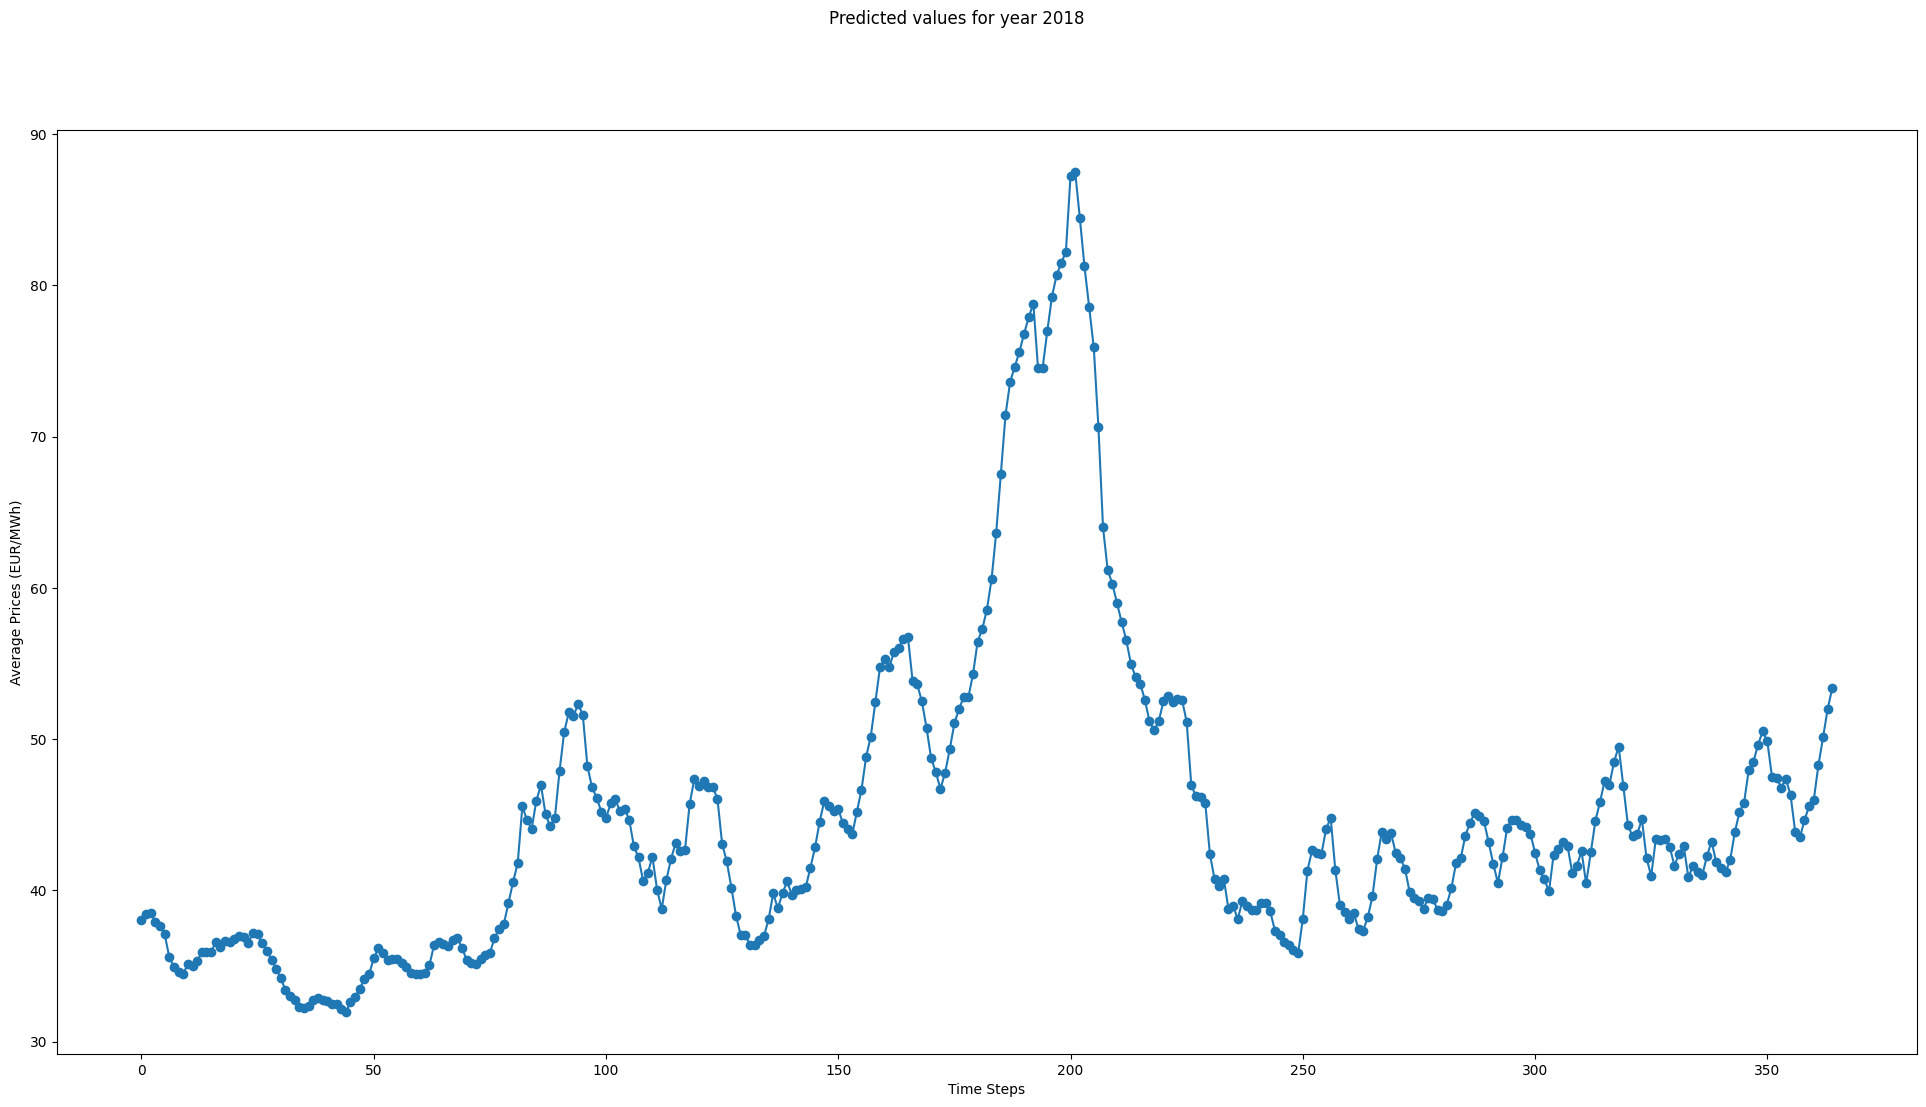

In [56]:
# Plotting the graph of the predicted average price for the year 2018
plt.figure(figsize=(24,12))
plt.plot(predictions_2018_df['Predicted_Average_Price'],marker='o')
plt.xlabel('Time Steps')
plt.ylabel('Average Prices (EUR/MWh)')
plt.suptitle('Predicted values for year 2018')
plt.show()

# Optimization

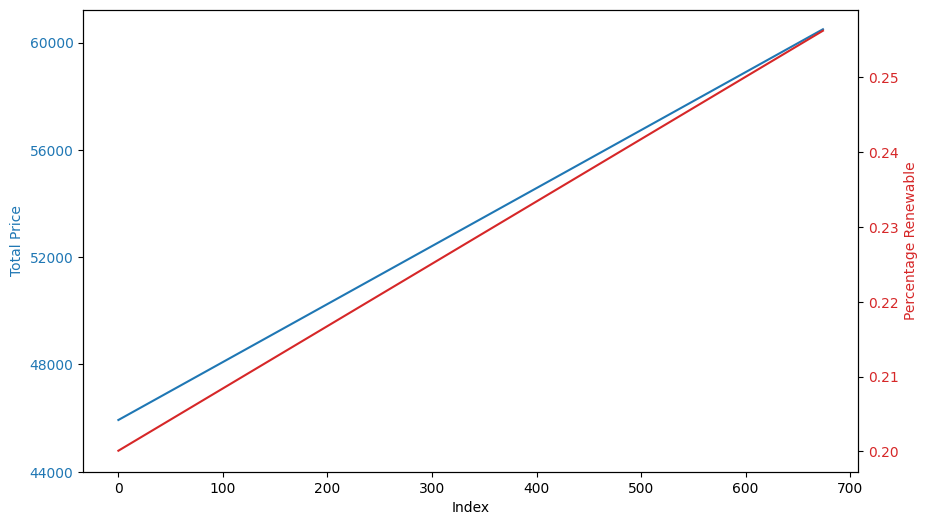

In [67]:
import pandas as pd

def calculate_results():
    results = []

    for Q_Grid in range(1051):
        Q_Exchange = 1050 - Q_Grid
        
        total_price = 57.62 * Q_Grid + 36 * Q_Exchange
        total_renewable = 0.15 * Q_Grid + 0.05 * Q_Exchange + 150
        percentage_renewable = total_renewable / 1200
        
        if percentage_renewable > 0.2:
            results.append({
                "Q_Grid": Q_Grid,
                "Q_Exchange": Q_Exchange,
                "Total Price": total_price,
                "Total Renewable": total_renewable,
                "Percentage Renewable": percentage_renewable
            })

    df_results = pd.DataFrame(results)
    return df_results

# Minimize Z = C_Grid * Q_Grid + C_Exchange * Q_Exchange + CO2_Grid * Q_Grid

# Example usage
df_results = calculate_results()
df_results
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Total Price on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Index')
ax1.set_ylabel('Total Price', color=color)
ax1.plot(df_results.index, df_results['Total Price'], color=color, label='Total Price')
ax1.tick_params(axis='y', labelcolor=color)

# Customize primary y-axis ticks
ax1_yticks = ax1.get_yticks()
ax1.set_yticks(ax1_yticks[::2])  # Set ticks at every second position

# Create secondary y-axis for Percentage Renewable
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Percentage Renewable', color=color)
ax2.plot(df_results.index, df_results['Percentage Renewable'], color=color, label='Percentage Renewable')
ax2.tick_params(axis='y', labelcolor=color)
plt.savefig('price_percentage.png')

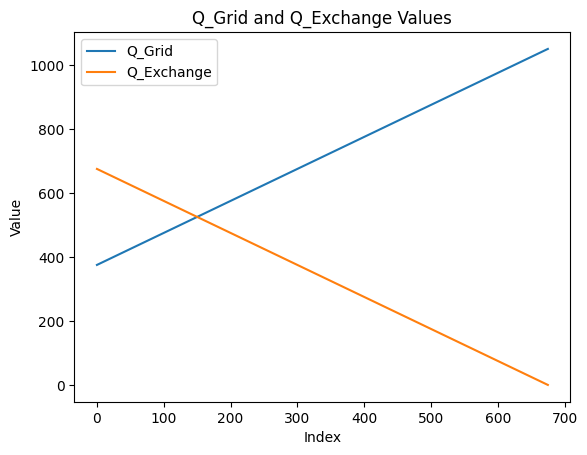

Point of Intersection:
     Q_Grid  Q_Exchange  Total Price  Percentage Renewable
150     525         525     49428.75                 21.25
Total Price at Intersection Point: 49428.75


In [68]:
def calculate_results():
    results = []

    for Q_Grid in range(1051):
        Q_Exchange = 1050 - Q_Grid
        
        if Q_Exchange < 0:
            continue  # Skip negative Q_Exchange values
        
        total_price = 57.62 * Q_Grid + 36.53 * Q_Exchange
        total_renewable = 0.15 * Q_Grid + 0.05 * Q_Exchange + 150
        percentage_renewable = total_renewable / 1200
        
        if percentage_renewable >= 0.2:
            results.append({
                "Q_Grid": Q_Grid,
                "Q_Exchange": Q_Exchange,
                "Total Price": total_price,
                "Percentage Renewable": percentage_renewable * 100  # Convert to percentage
            })

    df_results = pd.DataFrame(results)
    return df_results

# Calculate results
df_results = calculate_results()

# Plot Q_Grid and Q_Exchange
plt.plot(df_results['Q_Grid'], label='Q_Grid')
plt.plot(df_results['Q_Exchange'], label='Q_Exchange')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('Q_Grid and Q_Exchange Values')
plt.show()

# Find the point of intersection
intersection_point = df_results[df_results['Q_Grid'] == df_results['Q_Exchange']]
print("Point of Intersection:")
print(intersection_point)

# Calculate total price at the intersection point
total_price_intersection = intersection_point['Total Price'].iloc[0]
print("Total Price at Intersection Point:", total_price_intersection)

Chosen Point:
Q_Grid                   713.00
Q_Exchange               337.00
Total Price            53393.67
Percentage Renewable      22.82
Name: 338, dtype: float64


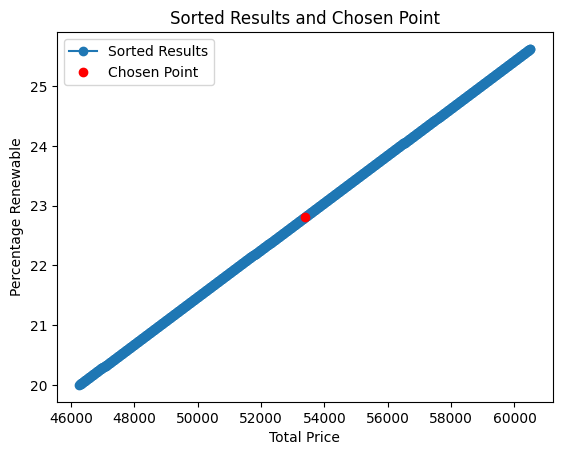

In [69]:
# Filter the DataFrame to select points where percentage renewable is greater than 20%
filtered_results = df_results[df_results['Percentage Renewable'] >= 20]

# Sort the filtered DataFrame by total price in ascending order
sorted_results = filtered_results.sort_values(by='Total Price')

# Select a point closer to the middle of the sorted DataFrame
chosen_index = len(sorted_results) // 2
chosen_point = sorted_results.iloc[chosen_index]

print("Chosen Point:")
print(chosen_point)
import matplotlib.pyplot as plt

# Plot the sorted results
plt.plot(sorted_results['Total Price'], sorted_results['Percentage Renewable'], 'o-', label='Sorted Results')

# Plot the chosen point
plt.plot(chosen_point['Total Price'], chosen_point['Percentage Renewable'], 'ro', label='Chosen Point')

# Add labels and title
plt.xlabel('Total Price')
plt.ylabel('Percentage Renewable')
plt.title('Sorted Results and Chosen Point')

# Add legend
plt.legend()
plt.savefig('sorted_results_and_chosen_point.png')
# Show plot
plt.show()